# Load required package

In [1]:
import tensorflow_datasets as tfds
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
import numpy as np
import pandas as pd 
import sklearn
from sklearn import feature_extraction, linear_model, model_selection, preprocessing, metrics
from sklearn.metrics.classification import precision_score 
from keras.callbacks import Callback
import os
import sys



/usr/local/python-3.7.5/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load the training data and the testing data

In [2]:
train_df = pd.read_csv("../data/train.csv")
test_df  = pd.read_csv("../data/test.csv")




# modified version 

In [3]:
class transformer():

    def __init__(self, X_data, y_data): 
        #use pre-trained tokenizers
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 
        self.max_length = 128 #512 maximum
        self.batch_size = 32 # 6 recommended 
        self.X_train, self.X_test, self.y_train, self.y_test = model_selection.train_test_split(X_data, y_data, test_size = 0.2, random_state = 1)
        self.train_encoded = None
        self.test_encoded  = None 
        self.model = None
        self.bert_history = None
        self.metric = None

    def convert_example_to_feature(self, review):
        # combine step for tokenization, WordPiece vector mapping, adding special tokens as well as truncating reviews longer than the max length
        return self.tokenizer.encode_plus(review, 
                                 add_special_tokens = True, # add [CLS], [SEP]
                                 max_length = self.max_length, # max length of the text that can go to BERT
                                 pad_to_max_length = True, # add [PAD] tokens
                                 return_attention_mask = True, # add attention mask to not focus on pad tokens
              )

    def map_example_to_dict(self, input_ids, attention_masks, token_type_ids):
        # map to the expected input to TFBertForSequenceClassification
        return {
        "input_ids": input_ids,
        "token_type_ids": token_type_ids,
        "attention_mask": attention_masks,
        } 

    def encode_examples(self, X_train):
        # prepare list, so that we can build up final TensorFlow dataset from slices.
        input_ids_list = []
        token_type_ids_list = []
        attention_mask_list = []
    
        for i in X_train.index: 
            bert_input = self.convert_example_to_feature(X_train[i])
            input_ids_list.append(bert_input['input_ids'])
            token_type_ids_list.append(bert_input['token_type_ids'])
            attention_mask_list.append(bert_input['attention_mask'])
            
    
        return np.array(input_ids_list), np.array(attention_mask_list), np.array(token_type_ids_list)

    def encoder(self):

        self.train_encoded = self.encode_examples(self.X_train) 
        self.test_encoded  = self.encode_examples(self.X_test) 

   

    #use already prepared TensorFlow models from transformers models
    def decoder(self, learning_rate = 5e-5, number_of_epochs = 2): 

        ## model initialization 

        # recommended learning rate for Adam 5e-5, 3e-5, 2e-5
        #learning_rate = 5e-5

        # we will do just 1 epoch for illustration, though multiple epochs might be better as                           long as we will not overfit the model
        #number_of_epochs = 1


        # model initialization
        self.model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2,return_dict = True)
    

        # choosing Adam optimizer
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)

        # we do not have one-hot vectors, we can use sparce categorical cross entropy and accuracy
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

        self.model.compile(optimizer=optimizer, loss=loss, metrics=[metric])



        ## fine tuning 
        self.metric = ClassificationReport(train_data=(self.train_encoded, self.y_train), validation_data=(self.test_encoded, self.y_test))

        self.bert_history = self.model.fit(self.train_encoded, self.y_train, callbacks = [self.metric],epochs=number_of_epochs, validation_data=(self.test_encoded, self.y_test), batch_size=self.batch_size)
        
        return self.bert_history
        

In [4]:
class ClassificationReport(Callback):
    
    def __init__(self, train_data=(), validation_data=()):
        super(Callback, self).__init__()
        
        self.X_train, self.y_train = train_data
        self.train_precision_scores = []
        self.train_recall_scores = []
        self.train_f1_scores = []
        
        self.X_val, self.y_val = validation_data
        self.val_precision_scores = []
        self.val_recall_scores = []
        self.val_f1_scores = [] 
               
    def on_epoch_end(self, epoch, logs={}):
        activation_train  = self.model.predict(self.X_train, verbose=0)
        train_predictions = np.argmax(tf.nn.softmax(activation_train[0], axis=-1), axis =1)         
        train_precision   = metrics.precision_score(self.y_train, train_predictions, average='macro')
        train_recall      = metrics.recall_score(self.y_train, train_predictions, average='macro')
        train_f1          = metrics.f1_score(self.y_train, train_predictions, average='macro')
        self.train_precision_scores.append(train_precision)        
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        activation_val  = self.model.predict(self.X_val, verbose=0)
        val_predictions = np.argmax(tf.nn.softmax(activation_val[0], axis=-1), axis =1)   
        val_precision   = metrics.precision_score(self.y_val, val_predictions, average='macro')
        val_recall      = metrics.recall_score(self.y_val, val_predictions, average='macro')
        val_f1          = metrics.f1_score(self.y_val, val_predictions, average='macro')
        self.val_precision_scores.append(val_precision)        
        self.val_recall_scores.append(val_recall)        
        self.val_f1_scores.append(val_f1)
        
        print('\nEpoch: {} - Training Precision: {:.6} - Training Recall: {:.6} - Training F1: {:.6}'.format(epoch + 1, train_precision, train_recall, train_f1))
        print('Epoch: {} - Validation Precision: {:.6} - Validation Recall: {:.6} - Validation F1: {:.6}'.format(epoch + 1, val_precision, val_recall, val_f1))  

## set up Encoder and decoder

In [5]:
Tran = transformer(train_df["keyword"].map(str) + '-' + train_df["location"].map(str) + '-' + train_df["text"].map(str), train_df["target"])
Tran.encoder()
Tran.decoder(number_of_epochs = 4)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


/usr/local/python-3.7.5/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertForSequenceClassification: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['dropout_37', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4


  1/191 [..............................] - ETA: 0s - loss: 0.8286 - accuracy: 0.3438

  2/191 [..............................] - ETA: 8:41 - loss: 0.7810 - accuracy: 0.4219

  3/191 [..............................] - ETA: 11:09 - loss: 0.7452 - accuracy: 0.4792

  4/191 [..............................] - ETA: 12:00 - loss: 0.7359 - accuracy: 0.4922

  5/191 [..............................] - ETA: 12:40 - loss: 0.7161 - accuracy: 0.5312

  6/191 [..............................] - ETA: 12:53 - loss: 0.7031 - accuracy: 0.5625

  7/191 [>.............................] - ETA: 13:02 - loss: 0.6852 - accuracy: 0.6027

  8/191 [>.............................] - ETA: 12:59 - loss: 0.6632 - accuracy: 0.6133

  9/191 [>.............................] - ETA: 13:06 - loss: 0.6607 - accuracy: 0.6146

 10/191 [>.............................] - ETA: 13:03 - loss: 0.6554 - accuracy: 0.6219

 11/191 [>.............................] - ETA: 13:02 - loss: 0.6442 - accuracy: 0.6335

 12/191 [>.............................] - ETA: 13:01 - loss: 0.6415 - accuracy: 0.6380

 13/191 [=>............................] - ETA: 12:55 - loss: 0.6379 - accuracy: 0.6370

 14/191 [=>............................] - ETA: 12:49 - loss: 0.6379 - accuracy: 0.6362

 15/191 [=>............................] - ETA: 12:44 - loss: 0.6243 - accuracy: 0.6500

 16/191 [=>............................] - ETA: 12:37 - loss: 0.6179 - accuracy: 0.6582

 17/191 [=>............................] - ETA: 12:37 - loss: 0.6067 - accuracy: 0.6691

 18/191 [=>............................] - ETA: 12:33 - loss: 0.6149 - accuracy: 0.6684

 19/191 [=>............................] - ETA: 12:30 - loss: 0.6145 - accuracy: 0.6694

 20/191 [==>...........................] - ETA: 12:25 - loss: 0.6113 - accuracy: 0.6734

 21/191 [==>...........................] - ETA: 12:26 - loss: 0.6047 - accuracy: 0.6786

 22/191 [==>...........................] - ETA: 12:25 - loss: 0.6034 - accuracy: 0.6818

 23/191 [==>...........................] - ETA: 12:19 - loss: 0.6010 - accuracy: 0.6861

 24/191 [==>...........................] - ETA: 12:16 - loss: 0.5999 - accuracy: 0.6862

 25/191 [==>...........................] - ETA: 12:09 - loss: 0.6014 - accuracy: 0.6850

 26/191 [===>..........................] - ETA: 12:07 - loss: 0.5974 - accuracy: 0.6875

 27/191 [===>..........................] - ETA: 12:01 - loss: 0.5945 - accuracy: 0.6898

 28/191 [===>..........................] - ETA: 11:57 - loss: 0.5902 - accuracy: 0.6931

 29/191 [===>..........................] - ETA: 11:52 - loss: 0.5846 - accuracy: 0.6994

 30/191 [===>..........................] - ETA: 11:50 - loss: 0.5820 - accuracy: 0.7031

 31/191 [===>..........................] - ETA: 11:46 - loss: 0.5817 - accuracy: 0.7056

 32/191 [====>.........................] - ETA: 11:40 - loss: 0.5835 - accuracy: 0.7051

 33/191 [====>.........................] - ETA: 11:35 - loss: 0.5783 - accuracy: 0.7102

 34/191 [====>.........................] - ETA: 11:29 - loss: 0.5733 - accuracy: 0.7151

 35/191 [====>.........................] - ETA: 11:24 - loss: 0.5697 - accuracy: 0.7188

 36/191 [====>.........................] - ETA: 11:19 - loss: 0.5655 - accuracy: 0.7231

 37/191 [====>.........................] - ETA: 11:14 - loss: 0.5633 - accuracy: 0.7247

 38/191 [====>.........................] - ETA: 11:09 - loss: 0.5614 - accuracy: 0.7262

 39/191 [=====>........................] - ETA: 11:02 - loss: 0.5607 - accuracy: 0.7276

 40/191 [=====>........................] - ETA: 10:58 - loss: 0.5625 - accuracy: 0.7266

 41/191 [=====>........................] - ETA: 10:53 - loss: 0.5648 - accuracy: 0.7256

 42/191 [=====>........................] - ETA: 10:47 - loss: 0.5605 - accuracy: 0.7284

 43/191 [=====>........................] - ETA: 10:44 - loss: 0.5592 - accuracy: 0.7289

 44/191 [=====>........................] - ETA: 10:39 - loss: 0.5573 - accuracy: 0.7301

 45/191 [======>.......................] - ETA: 10:34 - loss: 0.5528 - accuracy: 0.7340

 46/191 [======>.......................] - ETA: 10:30 - loss: 0.5526 - accuracy: 0.7351

 47/191 [======>.......................] - ETA: 10:25 - loss: 0.5507 - accuracy: 0.7360

 48/191 [======>.......................] - ETA: 10:20 - loss: 0.5510 - accuracy: 0.7350

 49/191 [======>.......................] - ETA: 10:17 - loss: 0.5503 - accuracy: 0.7341

 50/191 [======>.......................] - ETA: 10:13 - loss: 0.5488 - accuracy: 0.7344

 51/191 [=======>......................] - ETA: 10:09 - loss: 0.5465 - accuracy: 0.7365

 52/191 [=======>......................] - ETA: 10:05 - loss: 0.5436 - accuracy: 0.7398

 53/191 [=======>......................] - ETA: 10:01 - loss: 0.5427 - accuracy: 0.7406

 54/191 [=======>......................] - ETA: 9:56 - loss: 0.5412 - accuracy: 0.7425 

 55/191 [=======>......................] - ETA: 9:52 - loss: 0.5404 - accuracy: 0.7432

 56/191 [=======>......................] - ETA: 9:48 - loss: 0.5396 - accuracy: 0.7450

 57/191 [=======>......................] - ETA: 9:43 - loss: 0.5396 - accuracy: 0.7451

 58/191 [========>.....................] - ETA: 9:39 - loss: 0.5415 - accuracy: 0.7435

 59/191 [========>.....................] - ETA: 9:34 - loss: 0.5400 - accuracy: 0.7442

 60/191 [========>.....................] - ETA: 9:29 - loss: 0.5394 - accuracy: 0.7448

 61/191 [========>.....................] - ETA: 9:24 - loss: 0.5388 - accuracy: 0.7454

 62/191 [========>.....................] - ETA: 9:20 - loss: 0.5380 - accuracy: 0.7455

 63/191 [========>.....................] - ETA: 9:15 - loss: 0.5368 - accuracy: 0.7470

 64/191 [=========>....................] - ETA: 9:10 - loss: 0.5334 - accuracy: 0.7495

 65/191 [=========>....................] - ETA: 9:05 - loss: 0.5314 - accuracy: 0.7505

 66/191 [=========>....................] - ETA: 9:01 - loss: 0.5328 - accuracy: 0.7500

 67/191 [=========>....................] - ETA: 8:56 - loss: 0.5310 - accuracy: 0.7514

 68/191 [=========>....................] - ETA: 8:52 - loss: 0.5322 - accuracy: 0.7500

 69/191 [=========>....................] - ETA: 8:47 - loss: 0.5327 - accuracy: 0.7500

 70/191 [=========>....................] - ETA: 8:42 - loss: 0.5297 - accuracy: 0.7522

 71/191 [==========>...................] - ETA: 8:37 - loss: 0.5286 - accuracy: 0.7535

 72/191 [==========>...................] - ETA: 8:33 - loss: 0.5252 - accuracy: 0.7556

 73/191 [==========>...................] - ETA: 8:28 - loss: 0.5233 - accuracy: 0.7573

 74/191 [==========>...................] - ETA: 8:23 - loss: 0.5215 - accuracy: 0.7584

 75/191 [==========>...................] - ETA: 8:19 - loss: 0.5216 - accuracy: 0.7575

 76/191 [==========>...................] - ETA: 8:14 - loss: 0.5189 - accuracy: 0.7595

 77/191 [===========>..................] - ETA: 8:09 - loss: 0.5197 - accuracy: 0.7593

 78/191 [===========>..................] - ETA: 8:05 - loss: 0.5191 - accuracy: 0.7592

 79/191 [===========>..................] - ETA: 8:01 - loss: 0.5168 - accuracy: 0.7603

 80/191 [===========>..................] - ETA: 7:56 - loss: 0.5149 - accuracy: 0.7613

 81/191 [===========>..................] - ETA: 7:51 - loss: 0.5127 - accuracy: 0.7627

 82/191 [===========>..................] - ETA: 7:46 - loss: 0.5120 - accuracy: 0.7637

 83/191 [============>.................] - ETA: 7:42 - loss: 0.5130 - accuracy: 0.7636

 84/191 [============>.................] - ETA: 7:38 - loss: 0.5125 - accuracy: 0.7645

 85/191 [============>.................] - ETA: 7:34 - loss: 0.5134 - accuracy: 0.7640

 86/191 [============>.................] - ETA: 7:29 - loss: 0.5112 - accuracy: 0.7649

 87/191 [============>.................] - ETA: 7:24 - loss: 0.5118 - accuracy: 0.7647

 88/191 [============>.................] - ETA: 7:20 - loss: 0.5100 - accuracy: 0.7663

 89/191 [============>.................] - ETA: 7:16 - loss: 0.5100 - accuracy: 0.7665

 90/191 [=============>................] - ETA: 7:11 - loss: 0.5089 - accuracy: 0.7663

 91/191 [=============>................] - ETA: 7:07 - loss: 0.5082 - accuracy: 0.7672

 92/191 [=============>................] - ETA: 7:02 - loss: 0.5068 - accuracy: 0.7683

 93/191 [=============>................] - ETA: 6:58 - loss: 0.5054 - accuracy: 0.7692

 94/191 [=============>................] - ETA: 6:53 - loss: 0.5040 - accuracy: 0.7709

 95/191 [=============>................] - ETA: 6:49 - loss: 0.5038 - accuracy: 0.7714

 96/191 [==============>...............] - ETA: 6:45 - loss: 0.5028 - accuracy: 0.7718

 97/191 [==============>...............] - ETA: 6:40 - loss: 0.5012 - accuracy: 0.7726

 98/191 [==============>...............] - ETA: 6:36 - loss: 0.5007 - accuracy: 0.7726

 99/191 [==============>...............] - ETA: 6:31 - loss: 0.4998 - accuracy: 0.7734

100/191 [==============>...............] - ETA: 6:27 - loss: 0.4995 - accuracy: 0.7731

101/191 [==============>...............] - ETA: 6:22 - loss: 0.4986 - accuracy: 0.7735

102/191 [===============>..............] - ETA: 6:18 - loss: 0.4964 - accuracy: 0.7745

103/191 [===============>..............] - ETA: 6:13 - loss: 0.4972 - accuracy: 0.7743

104/191 [===============>..............] - ETA: 6:09 - loss: 0.4952 - accuracy: 0.7749

105/191 [===============>..............] - ETA: 6:05 - loss: 0.4950 - accuracy: 0.7750

106/191 [===============>..............] - ETA: 6:00 - loss: 0.4931 - accuracy: 0.7756

107/191 [===============>..............] - ETA: 5:56 - loss: 0.4919 - accuracy: 0.7763

108/191 [===============>..............] - ETA: 5:52 - loss: 0.4922 - accuracy: 0.7763

109/191 [================>.............] - ETA: 5:48 - loss: 0.4917 - accuracy: 0.7769

110/191 [================>.............] - ETA: 5:43 - loss: 0.4906 - accuracy: 0.7776

111/191 [================>.............] - ETA: 5:39 - loss: 0.4906 - accuracy: 0.7779

112/191 [================>.............] - ETA: 5:35 - loss: 0.4909 - accuracy: 0.7773

113/191 [================>.............] - ETA: 5:31 - loss: 0.4890 - accuracy: 0.7782

114/191 [================>.............] - ETA: 5:27 - loss: 0.4879 - accuracy: 0.7791

115/191 [=================>............] - ETA: 5:22 - loss: 0.4860 - accuracy: 0.7802

116/191 [=================>............] - ETA: 5:18 - loss: 0.4845 - accuracy: 0.7812

117/191 [=================>............] - ETA: 5:14 - loss: 0.4833 - accuracy: 0.7815

118/191 [=================>............] - ETA: 5:10 - loss: 0.4816 - accuracy: 0.7826

119/191 [=================>............] - ETA: 5:05 - loss: 0.4827 - accuracy: 0.7820

120/191 [=================>............] - ETA: 5:01 - loss: 0.4807 - accuracy: 0.7833

121/191 [==================>...........] - ETA: 4:57 - loss: 0.4818 - accuracy: 0.7825

122/191 [==================>...........] - ETA: 4:52 - loss: 0.4810 - accuracy: 0.7830

123/191 [==================>...........] - ETA: 4:48 - loss: 0.4800 - accuracy: 0.7838

124/191 [==================>...........] - ETA: 4:44 - loss: 0.4793 - accuracy: 0.7843

125/191 [==================>...........] - ETA: 4:40 - loss: 0.4796 - accuracy: 0.7843

126/191 [==================>...........] - ETA: 4:36 - loss: 0.4817 - accuracy: 0.7837

127/191 [==================>...........] - ETA: 4:31 - loss: 0.4814 - accuracy: 0.7840

128/191 [===================>..........] - ETA: 4:27 - loss: 0.4821 - accuracy: 0.7834

129/191 [===================>..........] - ETA: 4:23 - loss: 0.4826 - accuracy: 0.7827

130/191 [===================>..........] - ETA: 4:19 - loss: 0.4832 - accuracy: 0.7825

131/191 [===================>..........] - ETA: 4:14 - loss: 0.4837 - accuracy: 0.7824

132/191 [===================>..........] - ETA: 4:10 - loss: 0.4823 - accuracy: 0.7834

133/191 [===================>..........] - ETA: 4:06 - loss: 0.4814 - accuracy: 0.7843

134/191 [====================>.........] - ETA: 4:02 - loss: 0.4820 - accuracy: 0.7836

135/191 [====================>.........] - ETA: 3:58 - loss: 0.4822 - accuracy: 0.7840

136/191 [====================>.........] - ETA: 3:53 - loss: 0.4817 - accuracy: 0.7842

137/191 [====================>.........] - ETA: 3:49 - loss: 0.4822 - accuracy: 0.7838

138/191 [====================>.........] - ETA: 3:45 - loss: 0.4833 - accuracy: 0.7831

139/191 [====================>.........] - ETA: 3:40 - loss: 0.4828 - accuracy: 0.7830

140/191 [====================>.........] - ETA: 3:36 - loss: 0.4831 - accuracy: 0.7830

141/191 [=====================>........] - ETA: 3:32 - loss: 0.4828 - accuracy: 0.7835

142/191 [=====================>........] - ETA: 3:28 - loss: 0.4833 - accuracy: 0.7832

143/191 [=====================>........] - ETA: 3:24 - loss: 0.4828 - accuracy: 0.7837

144/191 [=====================>........] - ETA: 3:19 - loss: 0.4826 - accuracy: 0.7839

145/191 [=====================>........] - ETA: 3:15 - loss: 0.4828 - accuracy: 0.7838

146/191 [=====================>........] - ETA: 3:11 - loss: 0.4824 - accuracy: 0.7840

147/191 [======================>.......] - ETA: 3:07 - loss: 0.4817 - accuracy: 0.7847

148/191 [======================>.......] - ETA: 3:02 - loss: 0.4815 - accuracy: 0.7846

149/191 [======================>.......] - ETA: 2:58 - loss: 0.4816 - accuracy: 0.7848

150/191 [======================>.......] - ETA: 2:54 - loss: 0.4803 - accuracy: 0.7856

151/191 [======================>.......] - ETA: 2:50 - loss: 0.4804 - accuracy: 0.7856

152/191 [======================>.......] - ETA: 2:45 - loss: 0.4792 - accuracy: 0.7862

153/191 [=======================>......] - ETA: 2:41 - loss: 0.4784 - accuracy: 0.7866

154/191 [=======================>......] - ETA: 2:37 - loss: 0.4771 - accuracy: 0.7871

155/191 [=======================>......] - ETA: 2:33 - loss: 0.4766 - accuracy: 0.7875

156/191 [=======================>......] - ETA: 2:28 - loss: 0.4767 - accuracy: 0.7877

157/191 [=======================>......] - ETA: 2:24 - loss: 0.4761 - accuracy: 0.7880

158/191 [=======================>......] - ETA: 2:20 - loss: 0.4758 - accuracy: 0.7884

159/191 [=======================>......] - ETA: 2:16 - loss: 0.4748 - accuracy: 0.7891

160/191 [========================>.....] - ETA: 2:11 - loss: 0.4752 - accuracy: 0.7891

161/191 [========================>.....] - ETA: 2:07 - loss: 0.4754 - accuracy: 0.7886

162/191 [========================>.....] - ETA: 2:03 - loss: 0.4742 - accuracy: 0.7892

163/191 [========================>.....] - ETA: 1:59 - loss: 0.4741 - accuracy: 0.7897

164/191 [========================>.....] - ETA: 1:54 - loss: 0.4732 - accuracy: 0.7902

165/191 [========================>.....] - ETA: 1:50 - loss: 0.4740 - accuracy: 0.7902

166/191 [=========================>....] - ETA: 1:46 - loss: 0.4734 - accuracy: 0.7905

167/191 [=========================>....] - ETA: 1:42 - loss: 0.4737 - accuracy: 0.7904

168/191 [=========================>....] - ETA: 1:37 - loss: 0.4727 - accuracy: 0.7913

169/191 [=========================>....] - ETA: 1:33 - loss: 0.4717 - accuracy: 0.7918

170/191 [=========================>....] - ETA: 1:29 - loss: 0.4709 - accuracy: 0.7925

171/191 [=========================>....] - ETA: 1:25 - loss: 0.4703 - accuracy: 0.7928

172/191 [==========================>...] - ETA: 1:20 - loss: 0.4694 - accuracy: 0.7932

173/191 [==========================>...] - ETA: 1:16 - loss: 0.4684 - accuracy: 0.7937

174/191 [==========================>...] - ETA: 1:12 - loss: 0.4689 - accuracy: 0.7936

175/191 [==========================>...] - ETA: 1:08 - loss: 0.4673 - accuracy: 0.7945

176/191 [==========================>...] - ETA: 1:03 - loss: 0.4661 - accuracy: 0.7953

177/191 [==========================>...] - ETA: 59s - loss: 0.4654 - accuracy: 0.7957 

178/191 [==========================>...] - ETA: 55s - loss: 0.4651 - accuracy: 0.7958

179/191 [===========================>..] - ETA: 51s - loss: 0.4646 - accuracy: 0.7963

180/191 [===========================>..] - ETA: 46s - loss: 0.4643 - accuracy: 0.7965

181/191 [===========================>..] - ETA: 42s - loss: 0.4634 - accuracy: 0.7971

182/191 [===========================>..] - ETA: 38s - loss: 0.4627 - accuracy: 0.7976

183/191 [===========================>..] - ETA: 33s - loss: 0.4621 - accuracy: 0.7980

184/191 [===========================>..] - ETA: 29s - loss: 0.4617 - accuracy: 0.7984

185/191 [============================>.] - ETA: 25s - loss: 0.4618 - accuracy: 0.7986

186/191 [============================>.] - ETA: 21s - loss: 0.4624 - accuracy: 0.7986

187/191 [============================>.] - ETA: 16s - loss: 0.4619 - accuracy: 0.7990

188/191 [============================>.] - ETA: 12s - loss: 0.4619 - accuracy: 0.7989

189/191 [============================>.] - ETA: 8s - loss: 0.4620 - accuracy: 0.7988 

190/191 [============================>.] - ETA: 4s - loss: 0.4629 - accuracy: 0.7984

191/191 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.7985


Epoch: 1 - Training Precision: 0.890339 - Training Recall: 0.885218 - Training F1: 0.887378
Epoch: 1 - Validation Precision: 0.81553 - Validation Recall: 0.812773 - Validation F1: 0.814015
191/191 [==============================] - 1172s 6s/step - loss: 0.4627 - accuracy: 0.7985 - val_loss: 0.4106 - val_accuracy: 0.8194


Epoch 2/4


  1/191 [..............................] - ETA: 0s - loss: 0.3264 - accuracy: 0.9062

  2/191 [..............................] - ETA: 6:44 - loss: 0.3349 - accuracy: 0.8750

  3/191 [..............................] - ETA: 8:37 - loss: 0.3058 - accuracy: 0.8854

  4/191 [..............................] - ETA: 9:46 - loss: 0.3445 - accuracy: 0.8750

  5/191 [..............................] - ETA: 10:29 - loss: 0.3285 - accuracy: 0.8875

  6/191 [..............................] - ETA: 10:40 - loss: 0.3112 - accuracy: 0.8906

  7/191 [>.............................] - ETA: 10:58 - loss: 0.2905 - accuracy: 0.9062

  8/191 [>.............................] - ETA: 11:09 - loss: 0.2802 - accuracy: 0.9180

  9/191 [>.............................] - ETA: 11:09 - loss: 0.2852 - accuracy: 0.9167

 10/191 [>.............................] - ETA: 11:14 - loss: 0.3030 - accuracy: 0.9031

 11/191 [>.............................] - ETA: 11:20 - loss: 0.3160 - accuracy: 0.8977

 12/191 [>.............................] - ETA: 11:21 - loss: 0.3192 - accuracy: 0.8932

 13/191 [=>............................] - ETA: 11:24 - loss: 0.3210 - accuracy: 0.8918

 14/191 [=>............................] - ETA: 11:27 - loss: 0.3203 - accuracy: 0.8929

 15/191 [=>............................] - ETA: 11:27 - loss: 0.3218 - accuracy: 0.8917

 16/191 [=>............................] - ETA: 11:24 - loss: 0.3179 - accuracy: 0.8926

 17/191 [=>............................] - ETA: 11:23 - loss: 0.3124 - accuracy: 0.8934

 18/191 [=>............................] - ETA: 11:23 - loss: 0.3077 - accuracy: 0.8958

 19/191 [=>............................] - ETA: 11:21 - loss: 0.3056 - accuracy: 0.8980

 20/191 [==>...........................] - ETA: 11:20 - loss: 0.3038 - accuracy: 0.9000

 21/191 [==>...........................] - ETA: 11:17 - loss: 0.3053 - accuracy: 0.8988

 22/191 [==>...........................] - ETA: 11:13 - loss: 0.3060 - accuracy: 0.8977

 23/191 [==>...........................] - ETA: 11:08 - loss: 0.3147 - accuracy: 0.8940

 24/191 [==>...........................] - ETA: 11:05 - loss: 0.3108 - accuracy: 0.8971

 25/191 [==>...........................] - ETA: 11:02 - loss: 0.3067 - accuracy: 0.8975

 26/191 [===>..........................] - ETA: 11:00 - loss: 0.3064 - accuracy: 0.8966

 27/191 [===>..........................] - ETA: 10:56 - loss: 0.3035 - accuracy: 0.8981

 28/191 [===>..........................] - ETA: 10:53 - loss: 0.3057 - accuracy: 0.8973

 29/191 [===>..........................] - ETA: 10:49 - loss: 0.3076 - accuracy: 0.8944

 30/191 [===>..........................] - ETA: 10:45 - loss: 0.3071 - accuracy: 0.8938

 31/191 [===>..........................] - ETA: 10:41 - loss: 0.3036 - accuracy: 0.8952

 32/191 [====>.........................] - ETA: 10:37 - loss: 0.3055 - accuracy: 0.8926

 33/191 [====>.........................] - ETA: 10:33 - loss: 0.3050 - accuracy: 0.8930

 34/191 [====>.........................] - ETA: 10:29 - loss: 0.3056 - accuracy: 0.8915

 35/191 [====>.........................] - ETA: 10:25 - loss: 0.3041 - accuracy: 0.8911

 36/191 [====>.........................] - ETA: 10:21 - loss: 0.3022 - accuracy: 0.8915

 37/191 [====>.........................] - ETA: 10:18 - loss: 0.2996 - accuracy: 0.8919

 38/191 [====>.........................] - ETA: 10:14 - loss: 0.3033 - accuracy: 0.8890

 39/191 [=====>........................] - ETA: 10:10 - loss: 0.3011 - accuracy: 0.8894

 40/191 [=====>........................] - ETA: 10:05 - loss: 0.2998 - accuracy: 0.8898

 41/191 [=====>........................] - ETA: 10:02 - loss: 0.3006 - accuracy: 0.8880

 42/191 [=====>........................] - ETA: 9:58 - loss: 0.2999 - accuracy: 0.8884 

 43/191 [=====>........................] - ETA: 9:55 - loss: 0.2985 - accuracy: 0.8895

 44/191 [=====>........................] - ETA: 9:50 - loss: 0.2976 - accuracy: 0.8906

 45/191 [======>.......................] - ETA: 9:45 - loss: 0.2965 - accuracy: 0.8917

 46/191 [======>.......................] - ETA: 9:42 - loss: 0.2939 - accuracy: 0.8933

 47/191 [======>.......................] - ETA: 9:37 - loss: 0.2921 - accuracy: 0.8943

 48/191 [======>.......................] - ETA: 9:34 - loss: 0.2929 - accuracy: 0.8932

 49/191 [======>.......................] - ETA: 9:29 - loss: 0.2921 - accuracy: 0.8929

 50/191 [======>.......................] - ETA: 9:26 - loss: 0.2928 - accuracy: 0.8931

 51/191 [=======>......................] - ETA: 9:22 - loss: 0.2902 - accuracy: 0.8940

 52/191 [=======>......................] - ETA: 9:18 - loss: 0.2874 - accuracy: 0.8954

 53/191 [=======>......................] - ETA: 9:14 - loss: 0.2899 - accuracy: 0.8927

 54/191 [=======>......................] - ETA: 9:10 - loss: 0.2909 - accuracy: 0.8924

 55/191 [=======>......................] - ETA: 9:06 - loss: 0.2904 - accuracy: 0.8920

 56/191 [=======>......................] - ETA: 9:03 - loss: 0.2884 - accuracy: 0.8929

 57/191 [=======>......................] - ETA: 8:58 - loss: 0.2885 - accuracy: 0.8931

 58/191 [========>.....................] - ETA: 8:54 - loss: 0.2892 - accuracy: 0.8928

 59/191 [========>.....................] - ETA: 8:50 - loss: 0.2890 - accuracy: 0.8925

 60/191 [========>.....................] - ETA: 8:46 - loss: 0.2902 - accuracy: 0.8927

 61/191 [========>.....................] - ETA: 8:43 - loss: 0.2909 - accuracy: 0.8924

 62/191 [========>.....................] - ETA: 8:39 - loss: 0.2893 - accuracy: 0.8926

 63/191 [========>.....................] - ETA: 8:35 - loss: 0.2908 - accuracy: 0.8919

 64/191 [=========>....................] - ETA: 8:31 - loss: 0.2907 - accuracy: 0.8921

 65/191 [=========>....................] - ETA: 8:27 - loss: 0.2914 - accuracy: 0.8928

 66/191 [=========>....................] - ETA: 8:23 - loss: 0.2896 - accuracy: 0.8939

 67/191 [=========>....................] - ETA: 8:20 - loss: 0.2880 - accuracy: 0.8946

 68/191 [=========>....................] - ETA: 8:17 - loss: 0.2858 - accuracy: 0.8957

 69/191 [=========>....................] - ETA: 8:13 - loss: 0.2863 - accuracy: 0.8940

 70/191 [=========>....................] - ETA: 8:09 - loss: 0.2872 - accuracy: 0.8938

 71/191 [==========>...................] - ETA: 8:06 - loss: 0.2892 - accuracy: 0.8935

 72/191 [==========>...................] - ETA: 8:02 - loss: 0.2903 - accuracy: 0.8924

 73/191 [==========>...................] - ETA: 7:59 - loss: 0.2898 - accuracy: 0.8921

 74/191 [==========>...................] - ETA: 7:55 - loss: 0.2914 - accuracy: 0.8919

 75/191 [==========>...................] - ETA: 7:51 - loss: 0.2923 - accuracy: 0.8917

 76/191 [==========>...................] - ETA: 7:47 - loss: 0.2903 - accuracy: 0.8927

 77/191 [===========>..................] - ETA: 7:43 - loss: 0.2910 - accuracy: 0.8920

 78/191 [===========>..................] - ETA: 7:39 - loss: 0.2894 - accuracy: 0.8926

 79/191 [===========>..................] - ETA: 7:35 - loss: 0.2883 - accuracy: 0.8928

 80/191 [===========>..................] - ETA: 7:31 - loss: 0.2864 - accuracy: 0.8938

 81/191 [===========>..................] - ETA: 7:27 - loss: 0.2870 - accuracy: 0.8935

 82/191 [===========>..................] - ETA: 7:23 - loss: 0.2870 - accuracy: 0.8929

 83/191 [============>.................] - ETA: 7:19 - loss: 0.2866 - accuracy: 0.8931

 84/191 [============>.................] - ETA: 7:15 - loss: 0.2855 - accuracy: 0.8936

 85/191 [============>.................] - ETA: 7:11 - loss: 0.2863 - accuracy: 0.8934

 86/191 [============>.................] - ETA: 7:07 - loss: 0.2873 - accuracy: 0.8921

 87/191 [============>.................] - ETA: 7:03 - loss: 0.2905 - accuracy: 0.8908

 88/191 [============>.................] - ETA: 6:59 - loss: 0.2908 - accuracy: 0.8906

 89/191 [============>.................] - ETA: 6:55 - loss: 0.2905 - accuracy: 0.8912

 90/191 [=============>................] - ETA: 6:51 - loss: 0.2910 - accuracy: 0.8910

 91/191 [=============>................] - ETA: 6:47 - loss: 0.2925 - accuracy: 0.8905

 92/191 [=============>................] - ETA: 6:42 - loss: 0.2926 - accuracy: 0.8906

 93/191 [=============>................] - ETA: 6:38 - loss: 0.2942 - accuracy: 0.8898

 94/191 [=============>................] - ETA: 6:34 - loss: 0.2939 - accuracy: 0.8896

 95/191 [=============>................] - ETA: 6:30 - loss: 0.2936 - accuracy: 0.8898

 96/191 [==============>...............] - ETA: 6:26 - loss: 0.2931 - accuracy: 0.8903

 97/191 [==============>...............] - ETA: 6:22 - loss: 0.2954 - accuracy: 0.8889

 98/191 [==============>...............] - ETA: 6:17 - loss: 0.2945 - accuracy: 0.8893

 99/191 [==============>...............] - ETA: 6:13 - loss: 0.2941 - accuracy: 0.8898

100/191 [==============>...............] - ETA: 6:10 - loss: 0.2954 - accuracy: 0.8891

101/191 [==============>...............] - ETA: 6:06 - loss: 0.2959 - accuracy: 0.8886

102/191 [===============>..............] - ETA: 6:02 - loss: 0.2965 - accuracy: 0.8885

103/191 [===============>..............] - ETA: 5:58 - loss: 0.2955 - accuracy: 0.8893

104/191 [===============>..............] - ETA: 5:54 - loss: 0.2949 - accuracy: 0.8897

105/191 [===============>..............] - ETA: 5:50 - loss: 0.2940 - accuracy: 0.8902

106/191 [===============>..............] - ETA: 5:46 - loss: 0.2929 - accuracy: 0.8903

107/191 [===============>..............] - ETA: 5:41 - loss: 0.2958 - accuracy: 0.8890

108/191 [===============>..............] - ETA: 5:37 - loss: 0.2960 - accuracy: 0.8886

109/191 [================>.............] - ETA: 5:33 - loss: 0.2972 - accuracy: 0.8879

110/191 [================>.............] - ETA: 5:29 - loss: 0.2975 - accuracy: 0.8878

111/191 [================>.............] - ETA: 5:25 - loss: 0.2966 - accuracy: 0.8880

112/191 [================>.............] - ETA: 5:21 - loss: 0.2983 - accuracy: 0.8873

113/191 [================>.............] - ETA: 5:17 - loss: 0.2995 - accuracy: 0.8869

114/191 [================>.............] - ETA: 5:14 - loss: 0.3003 - accuracy: 0.8860

115/191 [=================>............] - ETA: 5:09 - loss: 0.2995 - accuracy: 0.8867

116/191 [=================>............] - ETA: 5:06 - loss: 0.3002 - accuracy: 0.8863

117/191 [=================>............] - ETA: 5:01 - loss: 0.2996 - accuracy: 0.8865

118/191 [=================>............] - ETA: 4:57 - loss: 0.3015 - accuracy: 0.8856

119/191 [=================>............] - ETA: 4:53 - loss: 0.3019 - accuracy: 0.8852

120/191 [=================>............] - ETA: 4:49 - loss: 0.3027 - accuracy: 0.8844

121/191 [==================>...........] - ETA: 4:45 - loss: 0.3029 - accuracy: 0.8843

122/191 [==================>...........] - ETA: 4:41 - loss: 0.3026 - accuracy: 0.8847

123/191 [==================>...........] - ETA: 4:37 - loss: 0.3024 - accuracy: 0.8849

124/191 [==================>...........] - ETA: 4:33 - loss: 0.3031 - accuracy: 0.8851

125/191 [==================>...........] - ETA: 4:29 - loss: 0.3036 - accuracy: 0.8848

126/191 [==================>...........] - ETA: 4:25 - loss: 0.3027 - accuracy: 0.8857

127/191 [==================>...........] - ETA: 4:21 - loss: 0.3035 - accuracy: 0.8856

128/191 [===================>..........] - ETA: 4:17 - loss: 0.3035 - accuracy: 0.8850

129/191 [===================>..........] - ETA: 4:13 - loss: 0.3027 - accuracy: 0.8857

130/191 [===================>..........] - ETA: 4:09 - loss: 0.3040 - accuracy: 0.8849

131/191 [===================>..........] - ETA: 4:05 - loss: 0.3034 - accuracy: 0.8853

132/191 [===================>..........] - ETA: 4:01 - loss: 0.3029 - accuracy: 0.8854

133/191 [===================>..........] - ETA: 3:57 - loss: 0.3021 - accuracy: 0.8858

134/191 [====================>.........] - ETA: 3:53 - loss: 0.3022 - accuracy: 0.8855

135/191 [====================>.........] - ETA: 3:49 - loss: 0.3021 - accuracy: 0.8856

136/191 [====================>.........] - ETA: 3:45 - loss: 0.3027 - accuracy: 0.8856

137/191 [====================>.........] - ETA: 3:41 - loss: 0.3015 - accuracy: 0.8859

138/191 [====================>.........] - ETA: 3:37 - loss: 0.3016 - accuracy: 0.8859

139/191 [====================>.........] - ETA: 3:33 - loss: 0.3013 - accuracy: 0.8858

140/191 [====================>.........] - ETA: 3:28 - loss: 0.3028 - accuracy: 0.8853

141/191 [=====================>........] - ETA: 3:24 - loss: 0.3036 - accuracy: 0.8852

142/191 [=====================>........] - ETA: 3:20 - loss: 0.3032 - accuracy: 0.8856

143/191 [=====================>........] - ETA: 3:16 - loss: 0.3032 - accuracy: 0.8853

144/191 [=====================>........] - ETA: 3:12 - loss: 0.3024 - accuracy: 0.8852

145/191 [=====================>........] - ETA: 3:08 - loss: 0.3022 - accuracy: 0.8853

146/191 [=====================>........] - ETA: 3:04 - loss: 0.3020 - accuracy: 0.8851

147/191 [======================>.......] - ETA: 3:00 - loss: 0.3024 - accuracy: 0.8848

148/191 [======================>.......] - ETA: 2:56 - loss: 0.3050 - accuracy: 0.8841

149/191 [======================>.......] - ETA: 2:52 - loss: 0.3041 - accuracy: 0.8844

150/191 [======================>.......] - ETA: 2:48 - loss: 0.3040 - accuracy: 0.8844

151/191 [======================>.......] - ETA: 2:44 - loss: 0.3056 - accuracy: 0.8837

152/191 [======================>.......] - ETA: 2:40 - loss: 0.3060 - accuracy: 0.8832

153/191 [=======================>......] - ETA: 2:35 - loss: 0.3068 - accuracy: 0.8828

154/191 [=======================>......] - ETA: 2:31 - loss: 0.3070 - accuracy: 0.8827

155/191 [=======================>......] - ETA: 2:27 - loss: 0.3069 - accuracy: 0.8825

156/191 [=======================>......] - ETA: 2:23 - loss: 0.3078 - accuracy: 0.8824

157/191 [=======================>......] - ETA: 2:19 - loss: 0.3085 - accuracy: 0.8818

158/191 [=======================>......] - ETA: 2:15 - loss: 0.3081 - accuracy: 0.8821

159/191 [=======================>......] - ETA: 2:11 - loss: 0.3082 - accuracy: 0.8821

160/191 [========================>.....] - ETA: 2:07 - loss: 0.3080 - accuracy: 0.8818

161/191 [========================>.....] - ETA: 2:03 - loss: 0.3088 - accuracy: 0.8812

162/191 [========================>.....] - ETA: 1:58 - loss: 0.3101 - accuracy: 0.8804

163/191 [========================>.....] - ETA: 1:54 - loss: 0.3103 - accuracy: 0.8800

164/191 [========================>.....] - ETA: 1:50 - loss: 0.3094 - accuracy: 0.8805

165/191 [========================>.....] - ETA: 1:46 - loss: 0.3097 - accuracy: 0.8803

166/191 [=========================>....] - ETA: 1:42 - loss: 0.3095 - accuracy: 0.8805

167/191 [=========================>....] - ETA: 1:38 - loss: 0.3102 - accuracy: 0.8799

168/191 [=========================>....] - ETA: 1:34 - loss: 0.3115 - accuracy: 0.8793

169/191 [=========================>....] - ETA: 1:30 - loss: 0.3109 - accuracy: 0.8796

170/191 [=========================>....] - ETA: 1:26 - loss: 0.3108 - accuracy: 0.8796

171/191 [=========================>....] - ETA: 1:21 - loss: 0.3107 - accuracy: 0.8794

172/191 [==========================>...] - ETA: 1:17 - loss: 0.3109 - accuracy: 0.8794

173/191 [==========================>...] - ETA: 1:13 - loss: 0.3101 - accuracy: 0.8799

174/191 [==========================>...] - ETA: 1:09 - loss: 0.3096 - accuracy: 0.8798

175/191 [==========================>...] - ETA: 1:05 - loss: 0.3101 - accuracy: 0.8798

176/191 [==========================>...] - ETA: 1:01 - loss: 0.3096 - accuracy: 0.8803

177/191 [==========================>...] - ETA: 57s - loss: 0.3090 - accuracy: 0.8806 

178/191 [==========================>...] - ETA: 53s - loss: 0.3103 - accuracy: 0.8803

179/191 [===========================>..] - ETA: 49s - loss: 0.3096 - accuracy: 0.8804

180/191 [===========================>..] - ETA: 45s - loss: 0.3089 - accuracy: 0.8809

181/191 [===========================>..] - ETA: 40s - loss: 0.3103 - accuracy: 0.8800

182/191 [===========================>..] - ETA: 36s - loss: 0.3111 - accuracy: 0.8796

183/191 [===========================>..] - ETA: 32s - loss: 0.3128 - accuracy: 0.8789

184/191 [===========================>..] - ETA: 28s - loss: 0.3125 - accuracy: 0.8792

185/191 [============================>.] - ETA: 24s - loss: 0.3126 - accuracy: 0.8791

186/191 [============================>.] - ETA: 20s - loss: 0.3125 - accuracy: 0.8790

187/191 [============================>.] - ETA: 16s - loss: 0.3128 - accuracy: 0.8787

188/191 [============================>.] - ETA: 12s - loss: 0.3127 - accuracy: 0.8785

189/191 [============================>.] - ETA: 8s - loss: 0.3133 - accuracy: 0.8783 

190/191 [============================>.] - ETA: 4s - loss: 0.3139 - accuracy: 0.8780

191/191 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8773


Epoch: 2 - Training Precision: 0.947916 - Training Recall: 0.94491 - Training F1: 0.946287
Epoch: 2 - Validation Precision: 0.817952 - Validation Recall: 0.814047 - Validation F1: 0.815742
191/191 [==============================] - 1142s 6s/step - loss: 0.3149 - accuracy: 0.8773 - val_loss: 0.4077 - val_accuracy: 0.8214


Epoch 3/4


  1/191 [..............................] - ETA: 0s - loss: 0.2304 - accuracy: 0.9375

  2/191 [..............................] - ETA: 6:01 - loss: 0.2589 - accuracy: 0.9219

  3/191 [..............................] - ETA: 8:15 - loss: 0.2433 - accuracy: 0.9167

  4/191 [..............................] - ETA: 9:30 - loss: 0.2319 - accuracy: 0.9219

  5/191 [..............................] - ETA: 9:54 - loss: 0.2259 - accuracy: 0.9312

  6/191 [..............................] - ETA: 10:26 - loss: 0.2274 - accuracy: 0.9323

  7/191 [>.............................] - ETA: 10:44 - loss: 0.2150 - accuracy: 0.9420

  8/191 [>.............................] - ETA: 10:59 - loss: 0.2082 - accuracy: 0.9453

  9/191 [>.............................] - ETA: 11:03 - loss: 0.2322 - accuracy: 0.9236

 10/191 [>.............................] - ETA: 11:11 - loss: 0.2215 - accuracy: 0.9312

 11/191 [>.............................] - ETA: 11:18 - loss: 0.2161 - accuracy: 0.9318

 12/191 [>.............................] - ETA: 11:21 - loss: 0.2154 - accuracy: 0.9323

 13/191 [=>............................] - ETA: 11:27 - loss: 0.2037 - accuracy: 0.9375

 14/191 [=>............................] - ETA: 11:23 - loss: 0.1983 - accuracy: 0.9397

 15/191 [=>............................] - ETA: 11:21 - loss: 0.1916 - accuracy: 0.9438

 16/191 [=>............................] - ETA: 11:19 - loss: 0.1916 - accuracy: 0.9434

 17/191 [=>............................] - ETA: 11:16 - loss: 0.1892 - accuracy: 0.9449

 18/191 [=>............................] - ETA: 11:18 - loss: 0.1965 - accuracy: 0.9410

 19/191 [=>............................] - ETA: 11:13 - loss: 0.1930 - accuracy: 0.9424

 20/191 [==>...........................] - ETA: 11:14 - loss: 0.1921 - accuracy: 0.9422

 21/191 [==>...........................] - ETA: 11:14 - loss: 0.1947 - accuracy: 0.9405

 22/191 [==>...........................] - ETA: 11:12 - loss: 0.1958 - accuracy: 0.9389

 23/191 [==>...........................] - ETA: 11:09 - loss: 0.1947 - accuracy: 0.9375

 24/191 [==>...........................] - ETA: 11:05 - loss: 0.1915 - accuracy: 0.9388

 25/191 [==>...........................] - ETA: 11:03 - loss: 0.1861 - accuracy: 0.9413

 26/191 [===>..........................] - ETA: 11:00 - loss: 0.1834 - accuracy: 0.9423

 27/191 [===>..........................] - ETA: 10:56 - loss: 0.1810 - accuracy: 0.9421

 28/191 [===>..........................] - ETA: 10:53 - loss: 0.1766 - accuracy: 0.9442

 29/191 [===>..........................] - ETA: 10:49 - loss: 0.1717 - accuracy: 0.9461

 30/191 [===>..........................] - ETA: 10:46 - loss: 0.1729 - accuracy: 0.9448

 31/191 [===>..........................] - ETA: 10:44 - loss: 0.1800 - accuracy: 0.9425

 32/191 [====>.........................] - ETA: 10:41 - loss: 0.1760 - accuracy: 0.9434

 33/191 [====>.........................] - ETA: 10:37 - loss: 0.1834 - accuracy: 0.9422

 34/191 [====>.........................] - ETA: 10:33 - loss: 0.1815 - accuracy: 0.9430

 35/191 [====>.........................] - ETA: 10:30 - loss: 0.1830 - accuracy: 0.9429

 36/191 [====>.........................] - ETA: 10:26 - loss: 0.1797 - accuracy: 0.9436

 37/191 [====>.........................] - ETA: 10:22 - loss: 0.1827 - accuracy: 0.9417

 38/191 [====>.........................] - ETA: 10:19 - loss: 0.1799 - accuracy: 0.9424

 39/191 [=====>........................] - ETA: 10:15 - loss: 0.1813 - accuracy: 0.9423

 40/191 [=====>........................] - ETA: 10:11 - loss: 0.1854 - accuracy: 0.9406

 41/191 [=====>........................] - ETA: 10:07 - loss: 0.1830 - accuracy: 0.9413

 42/191 [=====>........................] - ETA: 10:03 - loss: 0.1842 - accuracy: 0.9405

 43/191 [=====>........................] - ETA: 9:58 - loss: 0.1831 - accuracy: 0.9411 

 44/191 [=====>........................] - ETA: 9:53 - loss: 0.1837 - accuracy: 0.9403

 45/191 [======>.......................] - ETA: 9:50 - loss: 0.1848 - accuracy: 0.9396

 46/191 [======>.......................] - ETA: 9:45 - loss: 0.1860 - accuracy: 0.9395

 47/191 [======>.......................] - ETA: 9:42 - loss: 0.1860 - accuracy: 0.9395

 48/191 [======>.......................] - ETA: 9:39 - loss: 0.1879 - accuracy: 0.9388

 49/191 [======>.......................] - ETA: 9:36 - loss: 0.1853 - accuracy: 0.9401

 50/191 [======>.......................] - ETA: 9:33 - loss: 0.1849 - accuracy: 0.9394

 51/191 [=======>......................] - ETA: 9:29 - loss: 0.1840 - accuracy: 0.9400

 52/191 [=======>......................] - ETA: 9:25 - loss: 0.1845 - accuracy: 0.9393

 53/191 [=======>......................] - ETA: 9:21 - loss: 0.1854 - accuracy: 0.9393

 54/191 [=======>......................] - ETA: 9:16 - loss: 0.1855 - accuracy: 0.9392

 55/191 [=======>......................] - ETA: 9:12 - loss: 0.1865 - accuracy: 0.9381

 56/191 [=======>......................] - ETA: 9:08 - loss: 0.1870 - accuracy: 0.9381

 57/191 [=======>......................] - ETA: 9:04 - loss: 0.1857 - accuracy: 0.9386

 58/191 [========>.....................] - ETA: 9:00 - loss: 0.1868 - accuracy: 0.9380

 59/191 [========>.....................] - ETA: 8:56 - loss: 0.1847 - accuracy: 0.9391

 60/191 [========>.....................] - ETA: 8:52 - loss: 0.1876 - accuracy: 0.9380

 61/191 [========>.....................] - ETA: 8:49 - loss: 0.1856 - accuracy: 0.9385

 62/191 [========>.....................] - ETA: 8:45 - loss: 0.1860 - accuracy: 0.9375

 63/191 [========>.....................] - ETA: 8:40 - loss: 0.1849 - accuracy: 0.9380

 64/191 [=========>....................] - ETA: 8:36 - loss: 0.1841 - accuracy: 0.9385

 65/191 [=========>....................] - ETA: 8:32 - loss: 0.1851 - accuracy: 0.9380

 66/191 [=========>....................] - ETA: 8:28 - loss: 0.1859 - accuracy: 0.9370

 67/191 [=========>....................] - ETA: 8:24 - loss: 0.1864 - accuracy: 0.9366

 68/191 [=========>....................] - ETA: 8:20 - loss: 0.1888 - accuracy: 0.9357

 69/191 [=========>....................] - ETA: 8:15 - loss: 0.1905 - accuracy: 0.9348

 70/191 [=========>....................] - ETA: 8:11 - loss: 0.1891 - accuracy: 0.9353

 71/191 [==========>...................] - ETA: 8:07 - loss: 0.1907 - accuracy: 0.9349

 72/191 [==========>...................] - ETA: 8:03 - loss: 0.1919 - accuracy: 0.9349

 73/191 [==========>...................] - ETA: 7:59 - loss: 0.1914 - accuracy: 0.9349

 74/191 [==========>...................] - ETA: 7:55 - loss: 0.1914 - accuracy: 0.9350

 75/191 [==========>...................] - ETA: 7:50 - loss: 0.1919 - accuracy: 0.9350

 76/191 [==========>...................] - ETA: 7:47 - loss: 0.1918 - accuracy: 0.9350

 77/191 [===========>..................] - ETA: 7:43 - loss: 0.1941 - accuracy: 0.9338

 78/191 [===========>..................] - ETA: 7:40 - loss: 0.1933 - accuracy: 0.9339

 79/191 [===========>..................] - ETA: 7:36 - loss: 0.1926 - accuracy: 0.9339

 80/191 [===========>..................] - ETA: 7:32 - loss: 0.1925 - accuracy: 0.9344

 81/191 [===========>..................] - ETA: 7:28 - loss: 0.1925 - accuracy: 0.9340

 82/191 [===========>..................] - ETA: 7:25 - loss: 0.1919 - accuracy: 0.9341

 83/191 [============>.................] - ETA: 7:20 - loss: 0.1924 - accuracy: 0.9341

 84/191 [============>.................] - ETA: 7:17 - loss: 0.1930 - accuracy: 0.9334

 85/191 [============>.................] - ETA: 7:12 - loss: 0.1928 - accuracy: 0.9331

 86/191 [============>.................] - ETA: 7:09 - loss: 0.1930 - accuracy: 0.9328

 87/191 [============>.................] - ETA: 7:05 - loss: 0.1939 - accuracy: 0.9332

 88/191 [============>.................] - ETA: 7:00 - loss: 0.1934 - accuracy: 0.9336

 89/191 [============>.................] - ETA: 6:57 - loss: 0.1925 - accuracy: 0.9340

 90/191 [=============>................] - ETA: 6:53 - loss: 0.1914 - accuracy: 0.9344

 91/191 [=============>................] - ETA: 6:49 - loss: 0.1918 - accuracy: 0.9341

 92/191 [=============>................] - ETA: 6:45 - loss: 0.1912 - accuracy: 0.9344

 93/191 [=============>................] - ETA: 6:41 - loss: 0.1906 - accuracy: 0.9348

 94/191 [=============>................] - ETA: 6:37 - loss: 0.1909 - accuracy: 0.9345

 95/191 [=============>................] - ETA: 6:33 - loss: 0.1936 - accuracy: 0.9329

 96/191 [==============>...............] - ETA: 6:29 - loss: 0.1924 - accuracy: 0.9333

 97/191 [==============>...............] - ETA: 6:25 - loss: 0.1922 - accuracy: 0.9336

 98/191 [==============>...............] - ETA: 6:21 - loss: 0.1907 - accuracy: 0.9343

 99/191 [==============>...............] - ETA: 6:17 - loss: 0.1897 - accuracy: 0.9347

100/191 [==============>...............] - ETA: 6:12 - loss: 0.1893 - accuracy: 0.9347

101/191 [==============>...............] - ETA: 6:09 - loss: 0.1889 - accuracy: 0.9347

102/191 [===============>..............] - ETA: 6:04 - loss: 0.1883 - accuracy: 0.9350

103/191 [===============>..............] - ETA: 6:01 - loss: 0.1889 - accuracy: 0.9345

104/191 [===============>..............] - ETA: 5:57 - loss: 0.1877 - accuracy: 0.9348

105/191 [===============>..............] - ETA: 5:52 - loss: 0.1882 - accuracy: 0.9345

106/191 [===============>..............] - ETA: 5:48 - loss: 0.1885 - accuracy: 0.9346

107/191 [===============>..............] - ETA: 5:44 - loss: 0.1898 - accuracy: 0.9340

108/191 [===============>..............] - ETA: 5:40 - loss: 0.1905 - accuracy: 0.9340

109/191 [================>.............] - ETA: 5:36 - loss: 0.1916 - accuracy: 0.9341

110/191 [================>.............] - ETA: 5:32 - loss: 0.1909 - accuracy: 0.9344

111/191 [================>.............] - ETA: 5:28 - loss: 0.1905 - accuracy: 0.9344

112/191 [================>.............] - ETA: 5:24 - loss: 0.1909 - accuracy: 0.9344

113/191 [================>.............] - ETA: 5:20 - loss: 0.1911 - accuracy: 0.9345

114/191 [================>.............] - ETA: 5:16 - loss: 0.1898 - accuracy: 0.9350

115/191 [=================>............] - ETA: 5:12 - loss: 0.1894 - accuracy: 0.9353

116/191 [=================>............] - ETA: 5:08 - loss: 0.1895 - accuracy: 0.9356

117/191 [=================>............] - ETA: 5:04 - loss: 0.1896 - accuracy: 0.9359

118/191 [=================>............] - ETA: 5:00 - loss: 0.1890 - accuracy: 0.9359

119/191 [=================>............] - ETA: 4:56 - loss: 0.1910 - accuracy: 0.9354

120/191 [=================>............] - ETA: 4:52 - loss: 0.1914 - accuracy: 0.9352

121/191 [==================>...........] - ETA: 4:48 - loss: 0.1907 - accuracy: 0.9357

122/191 [==================>...........] - ETA: 4:44 - loss: 0.1899 - accuracy: 0.9362

123/191 [==================>...........] - ETA: 4:40 - loss: 0.1896 - accuracy: 0.9365

124/191 [==================>...........] - ETA: 4:36 - loss: 0.1901 - accuracy: 0.9365

125/191 [==================>...........] - ETA: 4:31 - loss: 0.1911 - accuracy: 0.9362

126/191 [==================>...........] - ETA: 4:27 - loss: 0.1915 - accuracy: 0.9360

127/191 [==================>...........] - ETA: 4:23 - loss: 0.1913 - accuracy: 0.9358

128/191 [===================>..........] - ETA: 4:19 - loss: 0.1914 - accuracy: 0.9358

129/191 [===================>..........] - ETA: 4:15 - loss: 0.1913 - accuracy: 0.9358

130/191 [===================>..........] - ETA: 4:11 - loss: 0.1917 - accuracy: 0.9358

131/191 [===================>..........] - ETA: 4:07 - loss: 0.1914 - accuracy: 0.9358

132/191 [===================>..........] - ETA: 4:03 - loss: 0.1917 - accuracy: 0.9356

133/191 [===================>..........] - ETA: 3:59 - loss: 0.1919 - accuracy: 0.9352

134/191 [====================>.........] - ETA: 3:55 - loss: 0.1915 - accuracy: 0.9354

135/191 [====================>.........] - ETA: 3:51 - loss: 0.1906 - accuracy: 0.9359

136/191 [====================>.........] - ETA: 3:47 - loss: 0.1900 - accuracy: 0.9359

137/191 [====================>.........] - ETA: 3:43 - loss: 0.1898 - accuracy: 0.9359

138/191 [====================>.........] - ETA: 3:39 - loss: 0.1891 - accuracy: 0.9359

139/191 [====================>.........] - ETA: 3:35 - loss: 0.1889 - accuracy: 0.9359

140/191 [====================>.........] - ETA: 3:31 - loss: 0.1885 - accuracy: 0.9362

141/191 [=====================>........] - ETA: 3:27 - loss: 0.1880 - accuracy: 0.9364

142/191 [=====================>........] - ETA: 3:22 - loss: 0.1891 - accuracy: 0.9357

143/191 [=====================>........] - ETA: 3:18 - loss: 0.1898 - accuracy: 0.9358

144/191 [=====================>........] - ETA: 3:14 - loss: 0.1897 - accuracy: 0.9355

145/191 [=====================>........] - ETA: 3:10 - loss: 0.1899 - accuracy: 0.9353

146/191 [=====================>........] - ETA: 3:06 - loss: 0.1893 - accuracy: 0.9354

147/191 [======================>.......] - ETA: 3:01 - loss: 0.1897 - accuracy: 0.9349

148/191 [======================>.......] - ETA: 2:57 - loss: 0.1893 - accuracy: 0.9348

149/191 [======================>.......] - ETA: 2:53 - loss: 0.1894 - accuracy: 0.9344

150/191 [======================>.......] - ETA: 2:48 - loss: 0.1889 - accuracy: 0.9344

151/191 [======================>.......] - ETA: 2:44 - loss: 0.1882 - accuracy: 0.9346

152/191 [======================>.......] - ETA: 2:40 - loss: 0.1878 - accuracy: 0.9346

153/191 [=======================>......] - ETA: 2:36 - loss: 0.1885 - accuracy: 0.9346

154/191 [=======================>......] - ETA: 2:31 - loss: 0.1883 - accuracy: 0.9345

155/191 [=======================>......] - ETA: 2:27 - loss: 0.1877 - accuracy: 0.9345

156/191 [=======================>......] - ETA: 2:23 - loss: 0.1877 - accuracy: 0.9345

157/191 [=======================>......] - ETA: 2:19 - loss: 0.1874 - accuracy: 0.9347

158/191 [=======================>......] - ETA: 2:15 - loss: 0.1864 - accuracy: 0.9351

159/191 [=======================>......] - ETA: 2:10 - loss: 0.1857 - accuracy: 0.9353

160/191 [========================>.....] - ETA: 2:06 - loss: 0.1854 - accuracy: 0.9355

161/191 [========================>.....] - ETA: 2:02 - loss: 0.1858 - accuracy: 0.9356

162/191 [========================>.....] - ETA: 1:58 - loss: 0.1859 - accuracy: 0.9354

163/191 [========================>.....] - ETA: 1:54 - loss: 0.1852 - accuracy: 0.9356

164/191 [========================>.....] - ETA: 1:50 - loss: 0.1860 - accuracy: 0.9352

165/191 [========================>.....] - ETA: 1:46 - loss: 0.1853 - accuracy: 0.9354

166/191 [=========================>....] - ETA: 1:41 - loss: 0.1858 - accuracy: 0.9351

167/191 [=========================>....] - ETA: 1:37 - loss: 0.1861 - accuracy: 0.9351

168/191 [=========================>....] - ETA: 1:33 - loss: 0.1867 - accuracy: 0.9349

169/191 [=========================>....] - ETA: 1:29 - loss: 0.1870 - accuracy: 0.9347

170/191 [=========================>....] - ETA: 1:25 - loss: 0.1867 - accuracy: 0.9349

171/191 [=========================>....] - ETA: 1:21 - loss: 0.1872 - accuracy: 0.9346

172/191 [==========================>...] - ETA: 1:17 - loss: 0.1880 - accuracy: 0.9342

173/191 [==========================>...] - ETA: 1:13 - loss: 0.1877 - accuracy: 0.9344

174/191 [==========================>...] - ETA: 1:09 - loss: 0.1888 - accuracy: 0.9341

175/191 [==========================>...] - ETA: 1:04 - loss: 0.1883 - accuracy: 0.9343

176/191 [==========================>...] - ETA: 1:00 - loss: 0.1879 - accuracy: 0.9345

177/191 [==========================>...] - ETA: 56s - loss: 0.1876 - accuracy: 0.9347 

178/191 [==========================>...] - ETA: 52s - loss: 0.1874 - accuracy: 0.9347

179/191 [===========================>..] - ETA: 48s - loss: 0.1871 - accuracy: 0.9347

180/191 [===========================>..] - ETA: 44s - loss: 0.1873 - accuracy: 0.9347

181/191 [===========================>..] - ETA: 40s - loss: 0.1877 - accuracy: 0.9346

182/191 [===========================>..] - ETA: 36s - loss: 0.1883 - accuracy: 0.9344

183/191 [===========================>..] - ETA: 32s - loss: 0.1881 - accuracy: 0.9346

184/191 [===========================>..] - ETA: 28s - loss: 0.1878 - accuracy: 0.9346

185/191 [============================>.] - ETA: 24s - loss: 0.1881 - accuracy: 0.9343

186/191 [============================>.] - ETA: 20s - loss: 0.1887 - accuracy: 0.9341

187/191 [============================>.] - ETA: 16s - loss: 0.1885 - accuracy: 0.9343

188/191 [============================>.] - ETA: 12s - loss: 0.1888 - accuracy: 0.9343

189/191 [============================>.] - ETA: 8s - loss: 0.1885 - accuracy: 0.9347 

190/191 [============================>.] - ETA: 4s - loss: 0.1885 - accuracy: 0.9347

191/191 [==============================] - ETA: 0s - loss: 0.1885 - accuracy: 0.9346


Epoch: 3 - Training Precision: 0.971804 - Training Recall: 0.968387 - Training F1: 0.969947
Epoch: 3 - Validation Precision: 0.826432 - Validation Recall: 0.812973 - Validation F1: 0.817539
191/191 [==============================] - 1106s 6s/step - loss: 0.1885 - accuracy: 0.9346 - val_loss: 0.4921 - val_accuracy: 0.8253


Epoch 4/4


  1/191 [..............................] - ETA: 0s - loss: 0.1701 - accuracy: 0.9062

  2/191 [..............................] - ETA: 5:49 - loss: 0.1335 - accuracy: 0.9375

  3/191 [..............................] - ETA: 8:12 - loss: 0.1054 - accuracy: 0.9583

  4/191 [..............................] - ETA: 9:11 - loss: 0.1055 - accuracy: 0.9531

  5/191 [..............................] - ETA: 9:42 - loss: 0.0900 - accuracy: 0.9625

  6/191 [..............................] - ETA: 10:09 - loss: 0.0867 - accuracy: 0.9635

  7/191 [>.............................] - ETA: 10:18 - loss: 0.0949 - accuracy: 0.9598

  8/191 [>.............................] - ETA: 10:28 - loss: 0.0849 - accuracy: 0.9648

  9/191 [>.............................] - ETA: 10:35 - loss: 0.0962 - accuracy: 0.9618

 10/191 [>.............................] - ETA: 10:42 - loss: 0.1002 - accuracy: 0.9625

 11/191 [>.............................] - ETA: 10:46 - loss: 0.0922 - accuracy: 0.9659

 12/191 [>.............................] - ETA: 10:48 - loss: 0.0959 - accuracy: 0.9661

 13/191 [=>............................] - ETA: 10:52 - loss: 0.0947 - accuracy: 0.9663

 14/191 [=>............................] - ETA: 10:49 - loss: 0.0943 - accuracy: 0.9665

 15/191 [=>............................] - ETA: 10:50 - loss: 0.0899 - accuracy: 0.9688

 16/191 [=>............................] - ETA: 10:46 - loss: 0.0855 - accuracy: 0.9707

 17/191 [=>............................] - ETA: 10:46 - loss: 0.0818 - accuracy: 0.9724

 18/191 [=>............................] - ETA: 10:43 - loss: 0.0777 - accuracy: 0.9740

 19/191 [=>............................] - ETA: 10:39 - loss: 0.0877 - accuracy: 0.9720

 20/191 [==>...........................] - ETA: 10:37 - loss: 0.0865 - accuracy: 0.9719

 21/191 [==>...........................] - ETA: 10:34 - loss: 0.0854 - accuracy: 0.9717

 22/191 [==>...........................] - ETA: 10:32 - loss: 0.0891 - accuracy: 0.9702

 23/191 [==>...........................] - ETA: 10:31 - loss: 0.0904 - accuracy: 0.9701

 24/191 [==>...........................] - ETA: 10:26 - loss: 0.0911 - accuracy: 0.9688

 25/191 [==>...........................] - ETA: 10:22 - loss: 0.0913 - accuracy: 0.9688

 26/191 [===>..........................] - ETA: 10:20 - loss: 0.0925 - accuracy: 0.9688

 27/191 [===>..........................] - ETA: 10:17 - loss: 0.0974 - accuracy: 0.9676

 28/191 [===>..........................] - ETA: 10:14 - loss: 0.1085 - accuracy: 0.9654

 29/191 [===>..........................] - ETA: 10:11 - loss: 0.1100 - accuracy: 0.9644

 30/191 [===>..........................] - ETA: 10:08 - loss: 0.1099 - accuracy: 0.9635

 31/191 [===>..........................] - ETA: 10:06 - loss: 0.1083 - accuracy: 0.9637

 32/191 [====>.........................] - ETA: 10:02 - loss: 0.1072 - accuracy: 0.9648

 33/191 [====>.........................] - ETA: 10:00 - loss: 0.1058 - accuracy: 0.9650

 34/191 [====>.........................] - ETA: 9:56 - loss: 0.1033 - accuracy: 0.9660 

 35/191 [====>.........................] - ETA: 9:53 - loss: 0.1033 - accuracy: 0.9661

 36/191 [====>.........................] - ETA: 9:50 - loss: 0.1046 - accuracy: 0.9644

 37/191 [====>.........................] - ETA: 9:46 - loss: 0.1054 - accuracy: 0.9637

 38/191 [====>.........................] - ETA: 9:42 - loss: 0.1040 - accuracy: 0.9646

 39/191 [=====>........................] - ETA: 9:40 - loss: 0.1059 - accuracy: 0.9631

 40/191 [=====>........................] - ETA: 9:35 - loss: 0.1038 - accuracy: 0.9641

 41/191 [=====>........................] - ETA: 9:33 - loss: 0.1032 - accuracy: 0.9642

 42/191 [=====>........................] - ETA: 9:30 - loss: 0.1028 - accuracy: 0.9635

 43/191 [=====>........................] - ETA: 9:27 - loss: 0.1018 - accuracy: 0.9637

 44/191 [=====>........................] - ETA: 9:23 - loss: 0.0997 - accuracy: 0.9645

 45/191 [======>.......................] - ETA: 9:20 - loss: 0.1027 - accuracy: 0.9639

 46/191 [======>.......................] - ETA: 9:16 - loss: 0.1016 - accuracy: 0.9640

 47/191 [======>.......................] - ETA: 9:12 - loss: 0.0999 - accuracy: 0.9648

 48/191 [======>.......................] - ETA: 9:10 - loss: 0.1023 - accuracy: 0.9642

 49/191 [======>.......................] - ETA: 9:06 - loss: 0.1053 - accuracy: 0.9636

 50/191 [======>.......................] - ETA: 9:03 - loss: 0.1041 - accuracy: 0.9638

 51/191 [=======>......................] - ETA: 9:00 - loss: 0.1058 - accuracy: 0.9626

 52/191 [=======>......................] - ETA: 8:57 - loss: 0.1042 - accuracy: 0.9633

 53/191 [=======>......................] - ETA: 8:54 - loss: 0.1058 - accuracy: 0.9629

 54/191 [=======>......................] - ETA: 8:51 - loss: 0.1069 - accuracy: 0.9630

 55/191 [=======>......................] - ETA: 8:47 - loss: 0.1065 - accuracy: 0.9631

 56/191 [=======>......................] - ETA: 8:44 - loss: 0.1102 - accuracy: 0.9626

 57/191 [=======>......................] - ETA: 8:40 - loss: 0.1106 - accuracy: 0.9627

 58/191 [========>.....................] - ETA: 8:36 - loss: 0.1098 - accuracy: 0.9628

 59/191 [========>.....................] - ETA: 8:33 - loss: 0.1087 - accuracy: 0.9629

 60/191 [========>.....................] - ETA: 8:29 - loss: 0.1090 - accuracy: 0.9630

 61/191 [========>.....................] - ETA: 8:25 - loss: 0.1077 - accuracy: 0.9636

 62/191 [========>.....................] - ETA: 8:21 - loss: 0.1087 - accuracy: 0.9632

 63/191 [========>.....................] - ETA: 8:17 - loss: 0.1079 - accuracy: 0.9638

 64/191 [=========>....................] - ETA: 8:14 - loss: 0.1083 - accuracy: 0.9639

 65/191 [=========>....................] - ETA: 8:10 - loss: 0.1112 - accuracy: 0.9630

 66/191 [=========>....................] - ETA: 8:06 - loss: 0.1128 - accuracy: 0.9621

 67/191 [=========>....................] - ETA: 8:03 - loss: 0.1120 - accuracy: 0.9627

 68/191 [=========>....................] - ETA: 7:59 - loss: 0.1112 - accuracy: 0.9632

 69/191 [=========>....................] - ETA: 7:56 - loss: 0.1123 - accuracy: 0.9633

 70/191 [=========>....................] - ETA: 7:53 - loss: 0.1113 - accuracy: 0.9638

 71/191 [==========>...................] - ETA: 7:49 - loss: 0.1121 - accuracy: 0.9639

 72/191 [==========>...................] - ETA: 7:46 - loss: 0.1117 - accuracy: 0.9640

 73/191 [==========>...................] - ETA: 7:42 - loss: 0.1119 - accuracy: 0.9640

 74/191 [==========>...................] - ETA: 7:38 - loss: 0.1110 - accuracy: 0.9645

 75/191 [==========>...................] - ETA: 7:34 - loss: 0.1115 - accuracy: 0.9642

 76/191 [==========>...................] - ETA: 7:31 - loss: 0.1104 - accuracy: 0.9646

 77/191 [===========>..................] - ETA: 7:27 - loss: 0.1140 - accuracy: 0.9631

 78/191 [===========>..................] - ETA: 7:24 - loss: 0.1153 - accuracy: 0.9623

 79/191 [===========>..................] - ETA: 7:20 - loss: 0.1160 - accuracy: 0.9620

 80/191 [===========>..................] - ETA: 7:16 - loss: 0.1151 - accuracy: 0.9621

 81/191 [===========>..................] - ETA: 7:13 - loss: 0.1148 - accuracy: 0.9622

 82/191 [===========>..................] - ETA: 7:09 - loss: 0.1150 - accuracy: 0.9623

 83/191 [============>.................] - ETA: 7:05 - loss: 0.1147 - accuracy: 0.9623

 84/191 [============>.................] - ETA: 7:01 - loss: 0.1144 - accuracy: 0.9624

 85/191 [============>.................] - ETA: 6:57 - loss: 0.1151 - accuracy: 0.9618

 86/191 [============>.................] - ETA: 6:54 - loss: 0.1170 - accuracy: 0.9611

 87/191 [============>.................] - ETA: 6:50 - loss: 0.1162 - accuracy: 0.9616

 88/191 [============>.................] - ETA: 6:46 - loss: 0.1152 - accuracy: 0.9620

 89/191 [============>.................] - ETA: 6:42 - loss: 0.1167 - accuracy: 0.9614

 90/191 [=============>................] - ETA: 6:38 - loss: 0.1167 - accuracy: 0.9615

 91/191 [=============>................] - ETA: 6:35 - loss: 0.1174 - accuracy: 0.9615

 92/191 [=============>................] - ETA: 6:31 - loss: 0.1173 - accuracy: 0.9613

 93/191 [=============>................] - ETA: 6:27 - loss: 0.1174 - accuracy: 0.9610

 94/191 [=============>................] - ETA: 6:23 - loss: 0.1168 - accuracy: 0.9611

 95/191 [=============>................] - ETA: 6:19 - loss: 0.1158 - accuracy: 0.9615

 96/191 [==============>...............] - ETA: 6:15 - loss: 0.1161 - accuracy: 0.9616

 97/191 [==============>...............] - ETA: 6:11 - loss: 0.1157 - accuracy: 0.9620

 98/191 [==============>...............] - ETA: 6:07 - loss: 0.1168 - accuracy: 0.9614

 99/191 [==============>...............] - ETA: 6:03 - loss: 0.1159 - accuracy: 0.9618

100/191 [==============>...............] - ETA: 5:59 - loss: 0.1162 - accuracy: 0.9616

101/191 [==============>...............] - ETA: 5:55 - loss: 0.1161 - accuracy: 0.9616

102/191 [===============>..............] - ETA: 5:51 - loss: 0.1166 - accuracy: 0.9614

103/191 [===============>..............] - ETA: 5:47 - loss: 0.1174 - accuracy: 0.9612

104/191 [===============>..............] - ETA: 5:44 - loss: 0.1167 - accuracy: 0.9615

105/191 [===============>..............] - ETA: 5:39 - loss: 0.1177 - accuracy: 0.9613

106/191 [===============>..............] - ETA: 5:35 - loss: 0.1169 - accuracy: 0.9617

107/191 [===============>..............] - ETA: 5:31 - loss: 0.1180 - accuracy: 0.9612

108/191 [===============>..............] - ETA: 5:28 - loss: 0.1175 - accuracy: 0.9612

109/191 [================>.............] - ETA: 5:24 - loss: 0.1182 - accuracy: 0.9610

110/191 [================>.............] - ETA: 5:20 - loss: 0.1173 - accuracy: 0.9614

111/191 [================>.............] - ETA: 5:16 - loss: 0.1168 - accuracy: 0.9614

112/191 [================>.............] - ETA: 5:12 - loss: 0.1159 - accuracy: 0.9618

113/191 [================>.............] - ETA: 5:08 - loss: 0.1178 - accuracy: 0.9616

114/191 [================>.............] - ETA: 5:04 - loss: 0.1175 - accuracy: 0.9613

115/191 [=================>............] - ETA: 5:00 - loss: 0.1173 - accuracy: 0.9614

116/191 [=================>............] - ETA: 4:56 - loss: 0.1173 - accuracy: 0.9615

117/191 [=================>............] - ETA: 4:52 - loss: 0.1170 - accuracy: 0.9613

118/191 [=================>............] - ETA: 4:47 - loss: 0.1167 - accuracy: 0.9613

119/191 [=================>............] - ETA: 4:43 - loss: 0.1164 - accuracy: 0.9614

120/191 [=================>............] - ETA: 4:40 - loss: 0.1156 - accuracy: 0.9617

121/191 [==================>...........] - ETA: 4:36 - loss: 0.1148 - accuracy: 0.9620

122/191 [==================>...........] - ETA: 4:32 - loss: 0.1165 - accuracy: 0.9611

123/191 [==================>...........] - ETA: 4:28 - loss: 0.1165 - accuracy: 0.9606

124/191 [==================>...........] - ETA: 4:24 - loss: 0.1165 - accuracy: 0.9607

125/191 [==================>...........] - ETA: 4:20 - loss: 0.1173 - accuracy: 0.9605

126/191 [==================>...........] - ETA: 4:16 - loss: 0.1167 - accuracy: 0.9608

127/191 [==================>...........] - ETA: 4:12 - loss: 0.1164 - accuracy: 0.9609

128/191 [===================>..........] - ETA: 4:08 - loss: 0.1162 - accuracy: 0.9607

129/191 [===================>..........] - ETA: 4:04 - loss: 0.1156 - accuracy: 0.9610

130/191 [===================>..........] - ETA: 4:00 - loss: 0.1155 - accuracy: 0.9608

131/191 [===================>..........] - ETA: 3:56 - loss: 0.1160 - accuracy: 0.9606

132/191 [===================>..........] - ETA: 3:52 - loss: 0.1173 - accuracy: 0.9605

133/191 [===================>..........] - ETA: 3:48 - loss: 0.1181 - accuracy: 0.9603

134/191 [====================>.........] - ETA: 3:44 - loss: 0.1185 - accuracy: 0.9599

135/191 [====================>.........] - ETA: 3:40 - loss: 0.1178 - accuracy: 0.9602

136/191 [====================>.........] - ETA: 3:37 - loss: 0.1188 - accuracy: 0.9596

137/191 [====================>.........] - ETA: 3:33 - loss: 0.1194 - accuracy: 0.9592

138/191 [====================>.........] - ETA: 3:29 - loss: 0.1192 - accuracy: 0.9592

139/191 [====================>.........] - ETA: 3:25 - loss: 0.1196 - accuracy: 0.9591

140/191 [====================>.........] - ETA: 3:21 - loss: 0.1200 - accuracy: 0.9592

141/191 [=====================>........] - ETA: 3:17 - loss: 0.1202 - accuracy: 0.9590

142/191 [=====================>........] - ETA: 3:13 - loss: 0.1201 - accuracy: 0.9591

143/191 [=====================>........] - ETA: 3:09 - loss: 0.1199 - accuracy: 0.9591

144/191 [=====================>........] - ETA: 3:05 - loss: 0.1199 - accuracy: 0.9592

145/191 [=====================>........] - ETA: 3:01 - loss: 0.1202 - accuracy: 0.9588

146/191 [=====================>........] - ETA: 2:57 - loss: 0.1200 - accuracy: 0.9587

147/191 [======================>.......] - ETA: 2:53 - loss: 0.1206 - accuracy: 0.9583

148/191 [======================>.......] - ETA: 2:49 - loss: 0.1207 - accuracy: 0.9582

149/191 [======================>.......] - ETA: 2:46 - loss: 0.1205 - accuracy: 0.9583

150/191 [======================>.......] - ETA: 2:42 - loss: 0.1207 - accuracy: 0.9583

151/191 [======================>.......] - ETA: 2:38 - loss: 0.1202 - accuracy: 0.9586

152/191 [======================>.......] - ETA: 2:34 - loss: 0.1204 - accuracy: 0.9583

153/191 [=======================>......] - ETA: 2:30 - loss: 0.1201 - accuracy: 0.9583

154/191 [=======================>......] - ETA: 2:26 - loss: 0.1206 - accuracy: 0.9582

155/191 [=======================>......] - ETA: 2:22 - loss: 0.1205 - accuracy: 0.9581

156/191 [=======================>......] - ETA: 2:18 - loss: 0.1204 - accuracy: 0.9581

157/191 [=======================>......] - ETA: 2:14 - loss: 0.1199 - accuracy: 0.9584

158/191 [=======================>......] - ETA: 2:11 - loss: 0.1195 - accuracy: 0.9583

159/191 [=======================>......] - ETA: 2:07 - loss: 0.1206 - accuracy: 0.9581

160/191 [========================>.....] - ETA: 2:03 - loss: 0.1212 - accuracy: 0.9580

161/191 [========================>.....] - ETA: 1:59 - loss: 0.1210 - accuracy: 0.9581

162/191 [========================>.....] - ETA: 1:55 - loss: 0.1214 - accuracy: 0.9576

163/191 [========================>.....] - ETA: 1:51 - loss: 0.1210 - accuracy: 0.9576

164/191 [========================>.....] - ETA: 1:47 - loss: 0.1210 - accuracy: 0.9575

165/191 [========================>.....] - ETA: 1:43 - loss: 0.1208 - accuracy: 0.9576

166/191 [=========================>....] - ETA: 1:39 - loss: 0.1204 - accuracy: 0.9578

167/191 [=========================>....] - ETA: 1:35 - loss: 0.1215 - accuracy: 0.9573

168/191 [=========================>....] - ETA: 1:31 - loss: 0.1216 - accuracy: 0.9574

169/191 [=========================>....] - ETA: 1:27 - loss: 0.1225 - accuracy: 0.9571

170/191 [=========================>....] - ETA: 1:23 - loss: 0.1220 - accuracy: 0.9574

171/191 [=========================>....] - ETA: 1:19 - loss: 0.1219 - accuracy: 0.9572

172/191 [==========================>...] - ETA: 1:15 - loss: 0.1215 - accuracy: 0.9575

173/191 [==========================>...] - ETA: 1:11 - loss: 0.1215 - accuracy: 0.9572

174/191 [==========================>...] - ETA: 1:07 - loss: 0.1217 - accuracy: 0.9571

175/191 [==========================>...] - ETA: 1:03 - loss: 0.1217 - accuracy: 0.9570

176/191 [==========================>...] - ETA: 59s - loss: 0.1214 - accuracy: 0.9570 

177/191 [==========================>...] - ETA: 55s - loss: 0.1211 - accuracy: 0.9573

178/191 [==========================>...] - ETA: 52s - loss: 0.1208 - accuracy: 0.9573

179/191 [===========================>..] - ETA: 48s - loss: 0.1230 - accuracy: 0.9567

180/191 [===========================>..] - ETA: 44s - loss: 0.1232 - accuracy: 0.9566

181/191 [===========================>..] - ETA: 40s - loss: 0.1230 - accuracy: 0.9567

182/191 [===========================>..] - ETA: 36s - loss: 0.1224 - accuracy: 0.9569

183/191 [===========================>..] - ETA: 32s - loss: 0.1221 - accuracy: 0.9570

184/191 [===========================>..] - ETA: 28s - loss: 0.1229 - accuracy: 0.9569

185/191 [============================>.] - ETA: 24s - loss: 0.1223 - accuracy: 0.9571

186/191 [============================>.] - ETA: 20s - loss: 0.1220 - accuracy: 0.9572

187/191 [============================>.] - ETA: 16s - loss: 0.1218 - accuracy: 0.9572

188/191 [============================>.] - ETA: 12s - loss: 0.1230 - accuracy: 0.9566

189/191 [============================>.] - ETA: 8s - loss: 0.1236 - accuracy: 0.9565 

190/191 [============================>.] - ETA: 4s - loss: 0.1237 - accuracy: 0.9563

191/191 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.9562


Epoch: 4 - Training Precision: 0.955126 - Training Recall: 0.960436 - Training F1: 0.957113
Epoch: 4 - Validation Precision: 0.761212 - Validation Recall: 0.766174 - Validation F1: 0.752748
191/191 [==============================] - 1134s 6s/step - loss: 0.1237 - accuracy: 0.9562 - val_loss: 0.7386 - val_accuracy: 0.7531


## Retrieve the result 

In [6]:
import plotnine as p9
import pandas as pd
plot_df_train =  pd.DataFrame({'precision' :  Tran.metric.train_precision_scores, 'recall': Tran.metric.train_recall_scores, 'f1' : Tran.metric.train_f1_scores})
plot_df_val =  pd.DataFrame({'precision' :  Tran.metric.val_precision_scores, 'recall': Tran.metric.val_recall_scores, 'f1' : Tran.metric.val_f1_scores})

In [7]:
plot_df_train["index"] = plot_df_train.index + 1
plot_df_train = plot_df_train.melt(id_vars=["index"], var_name="metric", value_name="value")
plot_df_val["index"] = plot_df_val.index + 1
plot_df_val = plot_df_val.melt(id_vars=["index"], var_name="metric", value_name="value")

In [8]:
plot_df_train

,index,metric,value
0,1,precision,0.890339
1,2,precision,0.947916
2,3,precision,0.971804
3,4,precision,0.955126
4,1,recall,0.885218
5,2,recall,0.944910
6,3,recall,0.968387
7,4,recall,0.960436
8,1,f1,0.887378
9,2,f1,0.946287


In [9]:
plot_df_val

,index,metric,value
0,1,precision,0.815530
1,2,precision,0.817952
2,3,precision,0.826432
3,4,precision,0.761212
4,1,recall,0.812773
5,2,recall,0.814047
6,3,recall,0.812973
7,4,recall,0.766174
8,1,f1,0.814015
9,2,f1,0.815742


## Visualization 

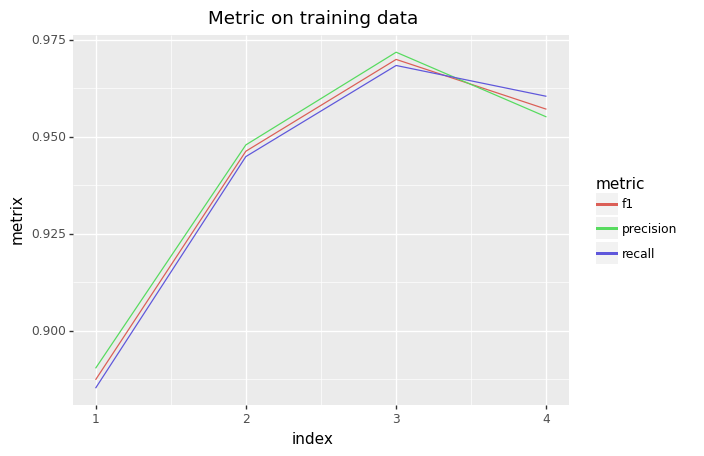

<ggplot: (8785850592441)>

In [10]:
p9.ggplot(plot_df_train) +\
     p9.geom_line(p9.aes(x = 'index', y = 'value', colour = 'metric')) +\
     p9.labs(x = 'index', y = 'metrix', title="Metric on training data")

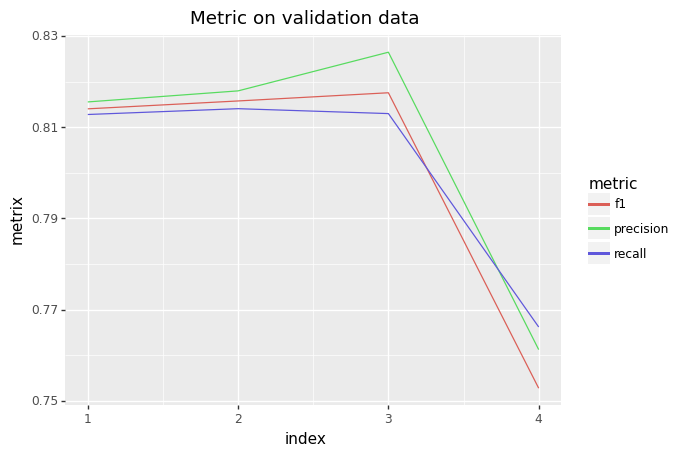

<ggplot: (8785821232221)>

In [11]:
p9.ggplot(plot_df_val) +\
     p9.geom_line(p9.aes(x = 'index', y = 'value', colour = 'metric')) +\
     p9.labs(x = 'index', y = 'metrix', title="Metric on validation data")